
# Uncertainty quantification with PnP-ULA.

This code shows you how to use sampling algorithms to quantify uncertainty of a reconstruction
from incomplete and noisy measurements.

ULA obtains samples by running the following iteration:

\begin{align}x_{k+1} = x_k +  \alpha \eta \nabla \log p_{\sigma}(x_k) + \eta \nabla \log p(y|x_k)  + \sqrt{2 \eta} z_k\end{align}

where $z_k \sim \mathcal{N}(0, I)$ is a Gaussian random variable, $\eta$ is the step size and
$\alpha$ is a parameter controlling the regularization.

The PnP-ULA method is described in the paper ["Bayesian imaging using Plug & Play priors: when Langevin meets Tweedie
"](https://arxiv.org/abs/2103.04715).


In [1]:
import deepinv as dinv
from deepinv.utils.plotting import plot
import torch
from deepinv.utils.demo import load_url_image

c:\Users\jbhim\miniconda3\envs\altegrad\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load image from the internet

This example uses an image of Lionel Messi from Wikipedia.



In [2]:
device = dinv.utils.get_freer_gpu() if torch.cuda.is_available() else "cpu"

url = (
    "https://upload.wikimedia.org/wikipedia/commons/b/b4/"
    "Lionel-Messi-Argentina-2022-FIFA-World-Cup_%28cropped%29.jpg"
)
x = load_url_image(url=url, img_size=32).to(device)

Selected GPU 0 with 4838 MB free memory 


## Define forward operator and noise model

This example uses inpainting as the forward operator and Gaussian noise as the noise model.



In [3]:
sigma = 0.1  # noise level
physics = dinv.physics.Inpainting(mask=0.5, tensor_size=x.shape[1:], device=device)
physics.noise_model = dinv.physics.GaussianNoise(sigma=sigma)

# Set the global random seed from pytorch to ensure reproducibility of the example.
torch.manual_seed(0)

## Define the likelihood

Since the noise model is Gaussian, the negative log-likelihood is the L2 loss.

\begin{align}-\log p(y|x) \propto \frac{1}{2\sigma^2} \|y-Ax\|^2\end{align}



In [4]:
# load Gaussian Likelihood
likelihood = dinv.optim.L2(sigma=sigma)

## Define the prior

The score a distribution can be approximated using Tweedie's formula via the
:class:`deepinv.optim.ScorePrior` class.

\begin{align}\nabla \log p_{\sigma}(x) \approx \frac{1}{\sigma^2} \left(D(x,\sigma)-x\right)\end{align}

This example uses a pretrained DnCNN model.
From a Bayesian point of view, the score plays the role of the gradient of the
negative log prior
The hyperparameter ``sigma_denoiser`` ($sigma$) controls the strength of the prior.

In this example, we use a pretrained DnCNN model using the :class:`deepinv.loss.FNEJacobianSpectralNorm` loss,
which makes sure that the denoiser is firmly non-expansive (see
["Building firmly nonexpansive convolutional neural networks"](https://hal.science/hal-03139360)), and helps to
stabilize the sampling algorithm.



In [5]:
sigma_denoiser = 2 / 255
prior = dinv.optim.ScorePrior(
    denoiser=dinv.models.DnCNN(pretrained="download_lipschitz")
).to(device)

## Create the MCMC sampler

Here we use the Unadjusted Langevin Algorithm (ULA) to sample from the posterior defined in
:class:`deepinv.sampling.ULA`.
The hyperparameter ``step_size`` controls the step size of the MCMC sampler,
``regularization`` controls the strength of the prior and
``iterations`` controls the number of iterations of the sampler.



In [6]:
regularization = 0.9
step_size = 0.01 * (sigma**2)
iterations = int(5e3) if torch.cuda.is_available() else 10
f = dinv.sampling.ULA(
    prior=prior,
    data_fidelity=likelihood,
    max_iter=iterations,
    alpha=regularization,
    step_size=step_size,
    verbose=True,
    sigma=sigma_denoiser,
)

## Generate the measurement
We apply the forward model to generate the noisy measurement.



In [7]:
y = physics(x)

## Run sampling algorithm and plot results
The sampling algorithm returns the posterior mean and variance.
We compare the posterior mean with a simple linear reconstruction.



100%|██████████| 5000/5000 [00:14<00:00, 352.96it/s]


Monte Carlo sampling finished! elapsed time=14.18 seconds
Iteration 4999, current converge crit. = 8.46E-05, objective = 1.00E-03 
Linear reconstruction PSNR: 8.53 dB
Posterior mean PSNR: 19.41 dB


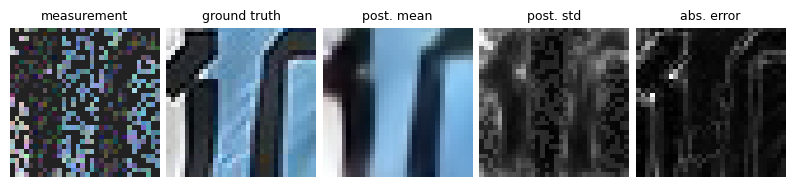

In [8]:
mean, var = f(y, physics)

# compute linear inverse
x_lin = physics.A_adjoint(y)

# compute PSNR
print(f"Linear reconstruction PSNR: {dinv.utils.metric.cal_psnr(x, x_lin):.2f} dB")
print(f"Posterior mean PSNR: {dinv.utils.metric.cal_psnr(x, mean):.2f} dB")

# plot results
error = (mean - x).abs().sum(dim=1).unsqueeze(1)  # per pixel average abs. error
std = var.sum(dim=1).unsqueeze(1).sqrt()  # per pixel average standard dev.
imgs = [x_lin, x, mean, std / std.flatten().max(), error / error.flatten().max()]
plot(
    imgs,
    titles=["measurement", "ground truth", "post. mean", "post. std", "abs. error"],
)